# Prediction: Pop vs. Rap

This notebook explores various algorithms' ability to classify songs as pop or rap. We also develop a classification technique based on comparing word distribution. Finally, we summarize all the results and end with a discussion.

In [1]:
import sys
sys.path.insert(0, "..//..//..//scripts")

import xgboost as xgb
import seaborn as sns
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from NonParametricClassifier import *
from CDFClassifier import *
from HelperFunctions import *
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

Two helpful functions:

In [3]:
def grid_search(x, y, num, clf, train, test, classes, compare, useprior):
    
    grid = {}
    grid2 = {}

    for n in np.linspace(x, y, num)[1:]:
        tclf = clf(alpha = float(n), compare = compare, useprior = useprior)
        tclf.fit(train, classes)
        grid.update({n: confusion_matrix(tclf.predict(test, classes), tclf.test_Y)})
        grid2.update({n: np.diag(grid[n]).sum() / grid[n].sum()})
    
    best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
    print("Best accuracy:", best[1])
    print("Parameter", best[0])

    plt.plot([i for i in grid2], [grid2[i] for i in grid2])
    
    return grid2

def create_genre(row, genre):
    if re.search(genre, row["Genre"], flags = re.I) != None:
        return 1
    else:
        return 0

First, we read in the data:

In [2]:
df = pd.read_csv("..//..//..//..//data//Weekly_data_tokenized.csv")

In [4]:
df["Pop"] = df.apply(lambda row: create_genre(row, "pop"), axis = 1)
df["Rap"] = df.apply(lambda row: create_genre(row, "rap"), axis = 1)

df = df[["word", "ID", "Pop", "Rap"]]

np.random.seed(1)

IDs = df.ID.unique()
np.random.shuffle(IDs)

train = df[df.ID.isin(IDs[:int(.8 * len(IDs))])]
test = df[df.ID.isin(IDs[int(.8 * len(IDs)):])]

## KL Divergence

Best accuracy: 0.8274809160305343
Parameter 2.019849246231156e-06


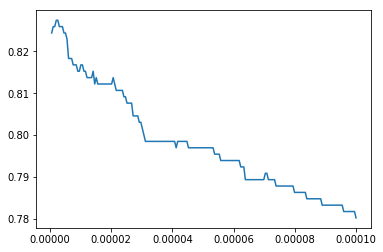

In [5]:
klgrid = grid_search(0.00000001, 0.0001, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "KL", False)

## Hellinger

Best accuracy: 0.8381679389312977
Parameter 2.412060301507538


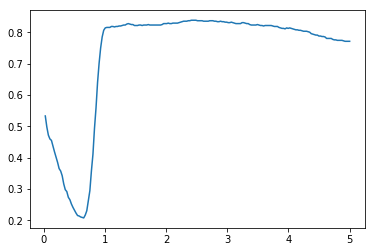

In [6]:
hellingergrid = grid_search(0, 5, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "hellinger", False)

## Mann-Whitney

In [7]:
def grid_search(x, y, num, clf, train, test, classes, compare):
    
    grid = {}
    grid2 = {}

    for n in np.linspace(x, y, num):
        tclf = clf(alpha = n, compare = compare)
        tclf.fit(train, classes)
        grid.update({n: confusion_matrix(tclf.predict(test, classes), tclf.test_Y)})
        grid2.update({n: np.diag(grid[n]).sum() / grid[n].sum()})
        
    best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
    print("Best accuracy:", best[1])
    print("Parameter", best[0])

    plt.plot([i for i in grid2], [grid2[i] for i in grid2])

Best accuracy: 0.7770992366412214
Parameter 0.73


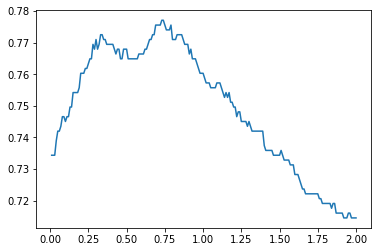

In [8]:
mwgrid = grid_search(0.01, 2, 200, CDFClassifier, train, test, ["Pop", "Rap"], "Mann-Whitney");

## Naive Bayes - Bernoulli

In [9]:
X_train, y_train, X_test, y_test = prepare_data(train, test)

Best accuracy: 0.8549618320610687
Parameter 0.005025125628140704


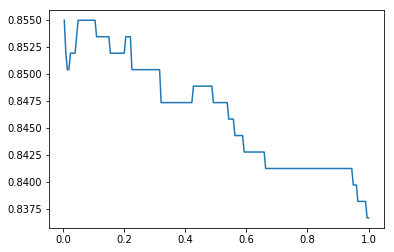

In [10]:
bernoulligrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = BernoulliNB(alpha = n)
    clf.fit(X_train, y_train)
    bernoulligrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(bernoulligrid[n]).sum() / bernoulligrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

## Naive Bayes - Multinomial

Best accuracy: 0.8305343511450382
Parameter 0.32160804020100503


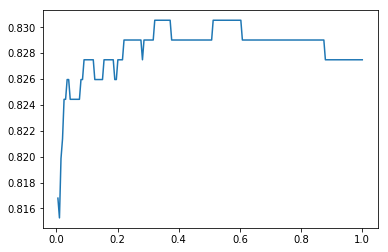

In [11]:
multigrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = MultinomialNB(alpha = n)
    clf.fit(X_train, y_train)
    multigrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(multigrid[n]).sum() / multigrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

## xgboost

In [12]:
def convert_genre(y):
    y = np.array(y)
    counts = Counter(y)
    itor = 0
    for genre in counts:
        y[y == genre] = itor
        itor += 1
    return y.astype(int)

In [13]:
y_train_binary = convert_genre(y_train)
y_test_binary = convert_genre(y_test)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train_binary)
dtest = xgb.DMatrix(X_test, label = y_test_binary)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

grid = {}
dims = 10

for l1 in np.linspace(0, 1, dims):
    for l2 in np.linspace(0, 1, dims):   
        param = {'max_depth': 1000, 'eta': 0.2, 'silent': 1, 'objective': 'binary:logistic', "alpha": l1,
                 "lambda": l2, "subsample": 0.9}
        bst = xgb.train(params = param, dtrain = dtrain, num_boost_round = 200, evals = evallist, early_stopping_rounds = 50)
        cfmat = confusion_matrix(bst.predict(dtest).round(), y_test_binary)
        grid.update({(l1, l2): np.diag(cfmat).sum() / cfmat.sum()})

In [15]:
mat = np.zeros((dims, dims))
row = 0
col = 0
for (r, c) in grid:
    mat[row, col] = grid[(r, c)]
    col += 1
    if (col) % dims == 0:
        if (row, col) == (0, 1):
            continue
        col = 0
        row += 1

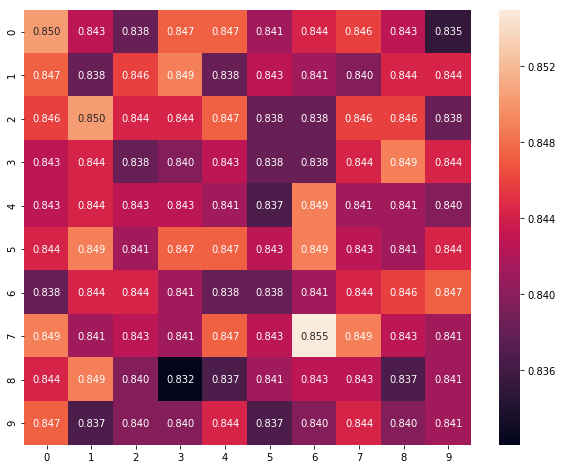

In [16]:
fig = plt.figure(figsize = (10, 8))
sns.heatmap(mat, annot = True, fmt = ".3f");

In [41]:
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

from tensorflow import Session, ConfigProto
sess = Session(config=ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1931788989141059310
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3159988633
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12858435694713129484
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
arch = [
    Dense(256, input_dim = 24714, activation = "sigmoid"),
    Dense(64, activation = "sigmoid"),
    Dense(8, activation = "sigmoid"),
    Dense(1, activation = "sigmoid")
]

model = Sequential(arch)

model.compile(
    optimizer = SGD(lr = 0.01),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

filepath = "weights-improvement-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    np.array(X_train), 
    np.array(y_train_binary),
    callbacks = callbacks_list,
    verbose = 1, 
    epochs = 20,
    batch_size = 2,
    validation_data = [np.array(X_test), np.array(y_test_binary)]
)

In [91]:
def plot_embedding(encoder, X, Y):
    fig = plt.figure(figsize = (12, 8))
    h = encoder.predict(np.array(X))
    y_tester = np.array(Y)
    for i in range(2):
        sel = y_tester == i
        plt.plot(h[sel, 0], h[sel, 1], '.', label='Group %d' % i, markersize = 3)
    plt.title('MLP embedding')
    plt.legend()
    plt.show()

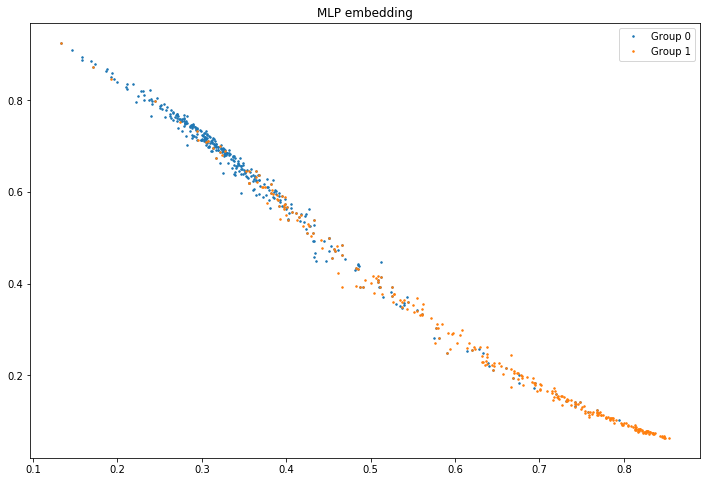

In [94]:
nn = load_model("weights-improvement-08-0.8260.h5")
model_tmp = Sequential(nn.layers[:-1])
plot_embedding(model_tmp, X_test, y_test_binary)

## Results



| KL    | Hellinger | Mann-Whitney | NB-Bernoulli | NB-Multinomial | xgboost | Neural network |
|:-----:|:---------:|:------------:|---|---|---|:---:|
|0.82748|  0.83817  |    0.7771    |0.85496|0.83053|<b>0.855</b>|0.826|